In [1]:
''' IMPORT ALL THE THINGS '''
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, smart_resize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [2]:
''' DEFINE VARIABLES '''

CWD = os.getcwd().replace('\\','/') # get current workspace directory
IMAGE_DIR = f'{CWD}/images'
TRAIN_DATASET_DIR = f'{IMAGE_DIR}/train'
TEST_DATASET_DIR = f'{IMAGE_DIR}/test'
VAL_DATASET_DIR = f'{IMAGE_DIR}/validation'

CATEGORIES = ['clementine','grapefruit','orange']

IMAGE_RESIZE = (224, 224) # size of image to put in Model

AUGMENT_N_IMAGE = 4 # how many time each image get the augmentation

AUGMENT_SAVE_PREFIX = 'aug'

Detail_model = 'resnet50_fc512_do01_fc256_fc3_aug'


In [3]:
''' Create Data Augmentation '''
def run_augmentation( isRun = 0 ):

    if isRun:

        print('Running Augmentation...\n')

        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect' # optional : nearest, constant(125), reflect, wrap
        ) 

        try:
            for category in CATEGORIES:

                train_image_in_directory = [] 

                train_category_directory = f"{TRAIN_DATASET_DIR}/{category}"

                for i, image_name in enumerate(os.listdir(train_category_directory)):
                    
                    file_path = f"{train_category_directory}/{image_name}"
                    
                    if (image_name.find(AUGMENT_SAVE_PREFIX) != -1):  # delete old augmentation
                        if (os.path.exists(file_path)):
                            os.remove(file_path)

                    elif (image_name.split('.')[1] in ['png', 'jpg', 'jpeg']):

                        image = load_img(file_path)
                        image = smart_resize(image, IMAGE_RESIZE)
                        image = img_to_array(image)
                        train_image_in_directory.append(image)

                train_image_in_directory = np.array(train_image_in_directory)
                print(f"{category} : ", end="")
                print(train_image_in_directory.shape)

                i = 0
                
                # save_to_dir (option) : f'{train_category_directory}', 'augmented'
                for batch in datagen.flow(train_image_in_directory, batch_size=1, save_to_dir=f'{train_category_directory}', save_prefix=AUGMENT_SAVE_PREFIX, save_format='jpg'):
                    i += 1
                    # datagen.flow make infinite loop NEED A MANUAL BREAK!!!
                    if i >= len(train_image_in_directory) * AUGMENT_N_IMAGE:
                        break

            print('\nAugmentation Success!!!')

        except Exception as e:

            print('\nAugmentation Failed...')
            print('Exception is\n',e)
    
    


In [4]:
run_augmentation(1)

Running Augmentation...

clementine : (485, 224, 224, 3)
grapefruit : (486, 224, 224, 3)
orange : (444, 224, 224, 3)

Augmentation Success!!!


In [5]:
''' LOAD DATA into Variables '''
try:
    print("Loading data...\n")
    
    print('-----------Train-----------')
    #Load train data

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DATASET_DIR, # train_data path
        image_size=IMAGE_RESIZE, # each image resize
        batch_size=1,
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(train_dataset.class_names)  # class check
    print(train_dataset)


    print("-----------Validation-----------")
    #Load validation data
    valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DATASET_DIR,  # validation_data path
        image_size=IMAGE_RESIZE,  # each image resize
        batch_size=1, 
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(valid_dataset.class_names)  # class check
    print(valid_dataset)

    print("\nLoad data Success!!!")
    
except Exception as e:

    print("\nLoad data failed...")
    print("Exception is",e)




Loading data...

-----------Train-----------
Found 7075 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
-----------Validation-----------
Found 469 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

Load data Success!!!


In [6]:
''' Get pre train model '''
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
resnet.trainable = False

Epoch 1/50
7075/7075 [==============================] - 638s 90ms/step - loss: 0.7129 - accuracy: 0.7524 - val_loss: 0.7020 - val_accuracy: 0.7932
Epoch 2/50
7075/7075 [==============================] - 643s 91ms/step - loss: 0.6005 - accuracy: 0.8098 - val_loss: 0.8374 - val_accuracy: 0.7868
Epoch 3/50
7075/7075 [==============================] - 639s 90ms/step - loss: 0.5908 - accuracy: 0.8205 - val_loss: 0.7245 - val_accuracy: 0.8166
Epoch 4/50
7075/7075 [==============================] - 640s 90ms/step - loss: 0.5492 - accuracy: 0.8397 - val_loss: 0.8176 - val_accuracy: 0.8124
Epoch 5/50
7075/7075 [==============================] - 637s 90ms/step - loss: 0.5362 - accuracy: 0.8454 - val_loss: 1.0367 - val_accuracy: 0.8060
Epoch 6/50
7075/7075 [==============================] - 640s 90ms/step - loss: 0.5186 - accuracy: 0.8489 - val_loss: 0.7808 - val_accuracy: 0.8124
Epoch 7/50
7075/7075 [==============================] - 635s 90ms/step - loss: 0.5438 - accuracy: 0.8502 - val_loss: 0

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss')]

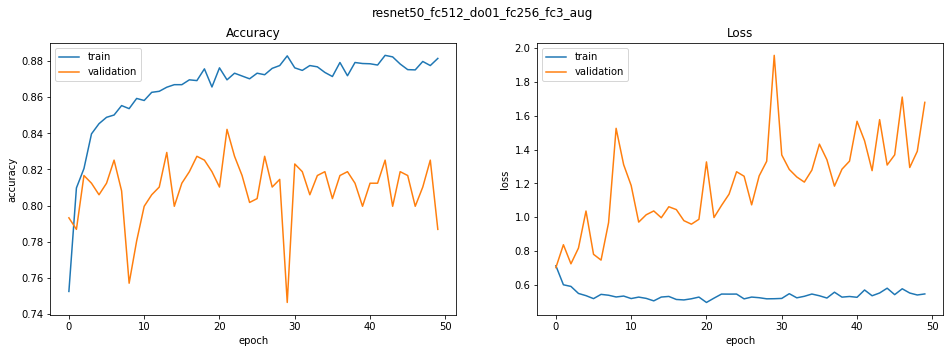

In [8]:
''' Training and Display result'''

# create model architecture
model = tf.keras.models.Sequential([
                                resnet,
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(3, activation='softmax')
])

# compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
los = tf.keras.losses.categorical_crossentropy
model.compile( optimizer = opt , loss = los , metrics = ['accuracy'] )

# Training
model.fit(
    
    train_dataset,  # both data and label cause we use preprocessing
    validation_data=valid_dataset,
    batch_size=256,
    epochs=50, ### can be change
    shuffle=True 
)

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(16,5))
fig.suptitle(f"{Detail_model}")
axs[0].plot(model.history.history['accuracy'])
axs[0].plot(model.history.history['val_accuracy'])
axs[0].set_title('Accuracy')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[0].set(xlabel='epoch', ylabel='accuracy')

axs[1].plot(model.history.history['loss'])
axs[1].plot(model.history.history['val_loss'])
axs[1].set_title('Loss')
axs[1].legend(['train', 'validation'], loc='upper left')
axs[1].set(xlabel='epoch', ylabel='loss')


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DATASET_DIR,  # test_dataset path
        image_size=IMAGE_RESIZE,  # each image resize
        batch_size=1, 
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

print(test_dataset.class_names)  # class check
print(test_dataset)

print("\nLoad data Success!!!")

In [ ]:
''' Save the model '''
# model.save(f'{CWD}/Model/{Detail_model}')
model_json = model.to_json()
with open(f'{CWD}/Model/resnet50_final_4ep/model.json','w') as json_file:
    json_file.write(model_json)
model.save_weights(f'{CWD}/Model/resnet50_final_4ep/weights.h5')

In [ ]:
model.evaluate(test_dataset)

In [ ]:
model.summary()

In [ ]:
img = tf.keras.preprocessing.image.load_img(f'{CWD}/images/test/clementine/1000.jpg', target_size=(224,224))
print(img)
plt.imshow(img)
plt.show()

X= tf.keras.preprocessing.image.img_to_array(img)
X= np.expand_dims(X,axis=0)
image = np.vstack([X])
val = model.predict(image)
print("Val : ",end="")
print(val[0])